# Реализация

In [98]:
!pip install plantcv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
import cv2

In [4]:
def read_image(path):
    return cv2.imread(path)

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [5]:
def togray(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY)
    return thresh

In [6]:
from skimage.morphology import skeletonize
from skimage.util import invert
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances
from plantcv import plantcv as pcv

def description(image, debug=None):
    pcv.params.debug = None
    tresh = togray(image)
    tresh = tresh[15:tresh.shape[0]-15, 15:tresh.shape[1]-15]
    kernel = np.ones((3, 3), 'uint8')
    erode_img = cv2.erode(tresh, kernel, iterations=6)
    dilate_img = cv2.dilate(erode_img, kernel, iterations=8)
    skeleton = pcv.morphology.skeletonize(mask=invert(dilate_img))
    ball = cv2.dilate(erode_img, kernel, iterations=18)
    #находим координаты вершин-шариков
    count_1 = (ball == 0).sum()
    x, y = ball.shape
    arr = np.argsort(np.ravel(ball))[:count_1] 
    vertex_ball = np.vstack([arr % y + 1, arr // y + 1]).T
    d = euclidean_distances(vertex_ball, vertex_ball)
    inx = []
    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[1]):
            if d[i][j] < 50:
                inx.append(j)   
    
    vertex_ball = np.delete(vertex_ball, inx, 0)
    
    # находим координаты терминальных вершин
    tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None)
    count_1 = (tip_pts_mask == 255).sum()
    x, y = tip_pts_mask.shape
    arr = np.argsort(np.ravel(tip_pts_mask))[::-1][:count_1] 
    vertex_end = np.vstack([arr % y + 1, arr // y + 1]).T
    d = euclidean_distances(vertex_end, vertex_end)
    inx = []
    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[1]):
            if d[i][j] < 50:
                inx.append(j)    
    
    vertex_end = np.delete(vertex_end, inx, 0)

    d = euclidean_distances(vertex_end, vertex_ball)
    inx = []
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            if d[i][j] < 50:
                inx.append(i) 
    
    vertex_end = np.delete(vertex_end, inx, 0)

    vertex_all = np.vstack([vertex_ball, vertex_end])
    
    seg_img, edge_objects = pcv.morphology.segment_skeleton(skel_img=skeleton, mask=dilate_img)
    
    angles_all = []
    p_all = []
    for i in range(len(edge_objects)):
        p = cv2.arcLength(edge_objects[i], True)
        angles = cv2.approxPolyDP(edge_objects[i], 0.05*p, True)
        angles = cv2.convexHull(angles)
        p = cv2.arcLength(angles, True)
        if p < 100:
          continue
        if angles.shape[0] > 2:
            x, y, z = angles.shape
            buf = angles.reshape(x, z)
            d = np.ravel(euclidean_distances(buf, buf))
            j, k = np.argmax(d) // x, np.argmax(d) % x
            angles = np.array([[buf[j]], [buf[k]]])
        p_all.append(p)
        angles_all.append(angles)
    
    set_vertex = set()
    angles_all_approx = []
    inx_ed = []
    for eg in range(len(angles_all)):
        d = euclidean_distances(angles_all[eg][:, 0, :], vertex_all)
        i, j = np.argmin(d, axis=1)
        set_vertex.add(i)
        set_vertex.add(j)
        angles = np.array([[vertex_all[i]], [vertex_all[j]]])
        inx_ed.append({i, j})
        angles_all_approx.append(angles)
    
    degree = np.zeros(vertex_all.shape[0])

    for i in inx_ed:
        j, k = list(i)
        degree[j] += 1
        degree[k] += 1

    degree[degree == 0] = 2
    inx = []
    for i in range(-len(vertex_end), -1, -1):
        if degree[i] != 1:
            inx.append(i)
    
    degree = np.delete(degree, inx)
    if debug:
        return Counter(degree.astype('int')), {'erode_img':erode_img,
                'dilate_img':dilate_img,
                'skeleton':skeleton,
                'ball':ball,
                'vertex_all':vertex_all,
                'vertex_ball':vertex_ball,
                'vertex_end':vertex_end,
                'edge_objects':edge_objects,
                'angles_all_approx':angles_all_approx}
    return Counter(degree.astype('int'))

In [135]:
def type_graph(image):
    c = description(image, debug=None)
    if c[5]:
      return 3
    
    if c[3] == 3:
      return 1
    
    if c[4] == 1:
      return  2
    
    if c[4] == 2:
      return 4

# Запуск

In [ ]:
# image = read_image(filename)
# type_graph(image)

# Эксперименты

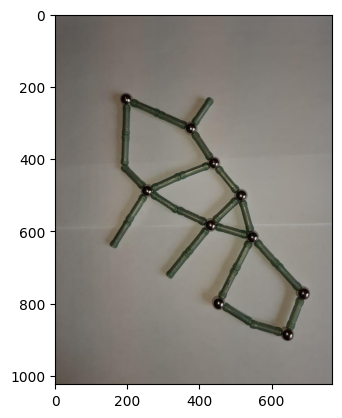

In [136]:
image = read_image('2.jpg')
show_image(image)

In [137]:
type_graph(image)

1

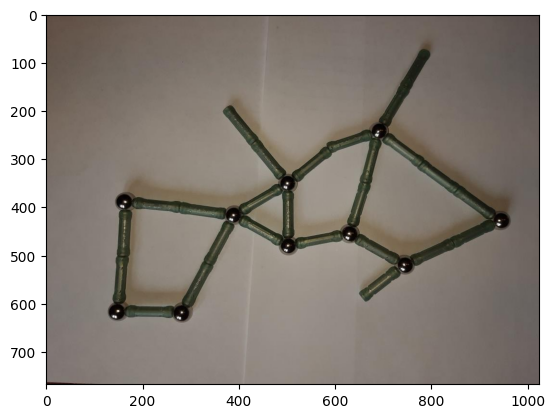

In [138]:
image = read_image('13.jpg')
show_image(image)

In [139]:
type_graph(image)

1

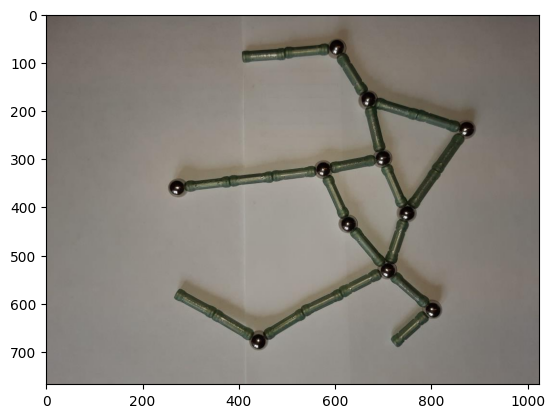

In [140]:
image = read_image('3.jpg')
show_image(image)

In [141]:
type_graph(image)

2

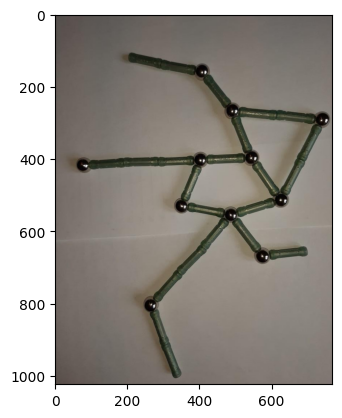

In [142]:
image = read_image('25.jpg')
show_image(image)

In [143]:
type_graph(image)

2

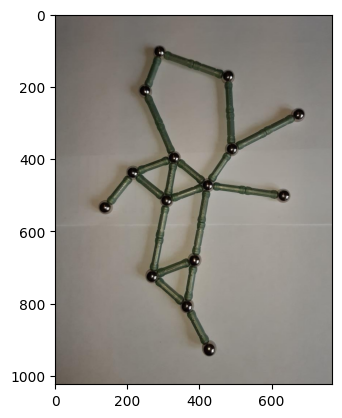

In [144]:
image = read_image('4.jpg')
show_image(image)

In [145]:
type_graph(image)

3

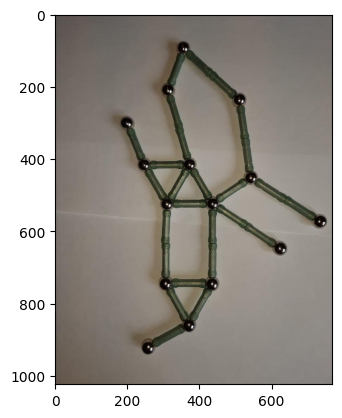

In [146]:
image = read_image('19.jpg')
show_image(image)

In [147]:
type_graph(image)

3

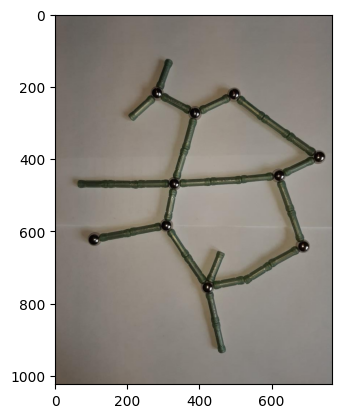

In [148]:
image = read_image('5.jpg')
show_image(image)

In [149]:
type_graph(image)

4

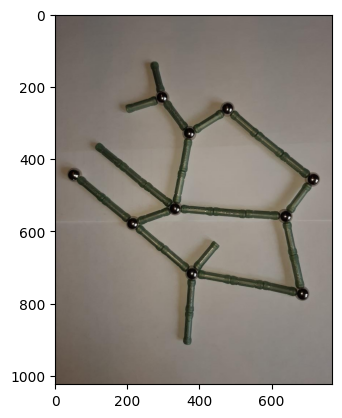

In [150]:
image = read_image('7.jpg')
show_image(image)

In [151]:
type_graph(image)

4

# Пошаговая реализация

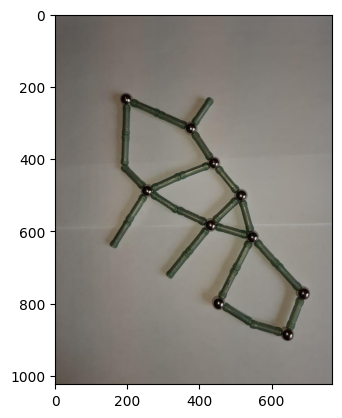

In [10]:
image = read_image('2.jpg')
show_image(image)

In [24]:
c, d = description(image, True)
c

Counter({3: 3, 4: 3, 2: 4, 1: 3})

In [25]:
d.keys()

dict_keys(['erode_img', 'dilate_img', 'skeleton', 'ball', 'vertex_all', 'vertex_ball', 'vertex_end', 'edge_objects', 'angles_all_approx'])

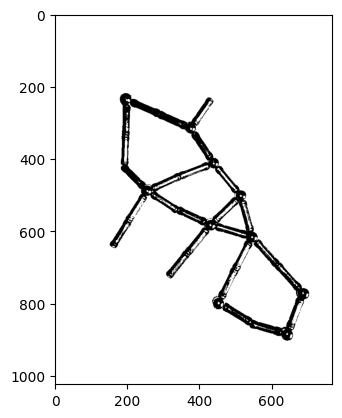

In [12]:
tresh = togray(image)
show_image(tresh)
plt.savefig('tresh.jpg')

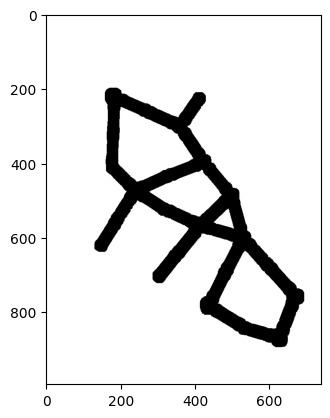

In [26]:
show_image(d['erode_img'])

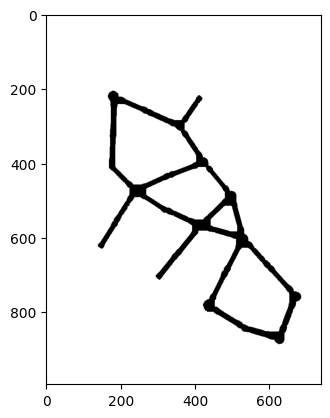

In [30]:
show_image(d['dilate_img'])
plt.savefig('bin.jpg')

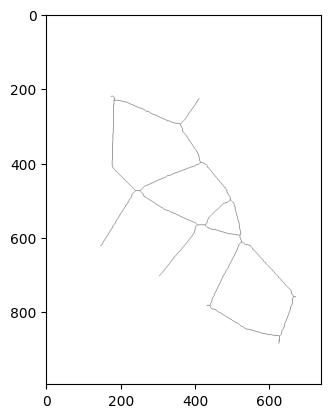

In [32]:
show_image(invert(d['skeleton']))
plt.savefig('skel.jpg')

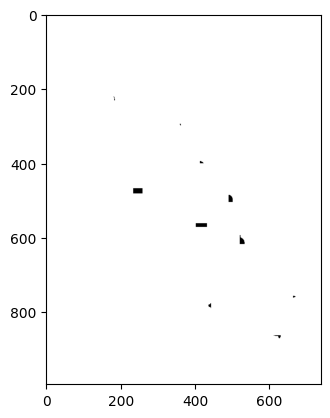

In [34]:
show_image(d['ball'])
plt.savefig('ball.jpg')

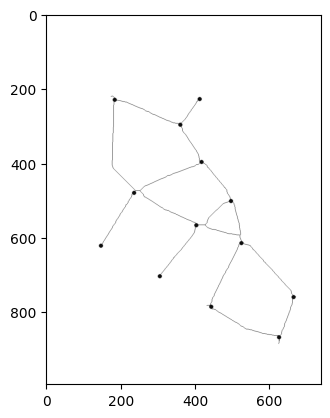

In [38]:
image_copy = invert(d['skeleton']).copy()
cv2.drawContours(image=image_copy, contours=d['vertex_all'][:, None, :], contourIdx=-1, color=(13, 255, 0), thickness=10, lineType=cv2.LINE_AA);
show_image(image_copy)
plt.savefig('vertex.jpg')

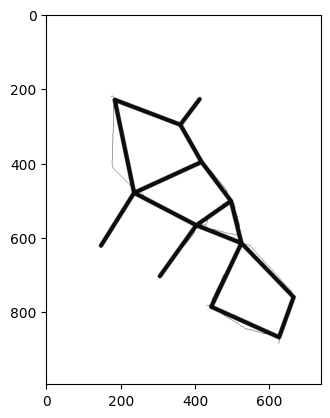

In [41]:
image_copy = invert(d['skeleton']).copy()
cv2.drawContours(image=image_copy, contours=d['angles_all_approx'], contourIdx=-1, color=(13, 255, 0), thickness=10, lineType=cv2.LINE_AA);
show_image(image_copy)
plt.savefig('angles.jpg')